## (Py)Tesseract Library

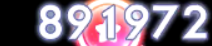

In [1]:
from PIL import Image
img = Image.open('snap0087.png')
display(img)

In [2]:
import pytesseract
dir(pytesseract)

['Output',
 'TSVNotSupported',
 'TesseractError',
 'TesseractNotFoundError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'get_tesseract_version',
 'image_to_boxes',
 'image_to_data',
 'image_to_osd',
 'image_to_pdf_or_hocr',
 'image_to_string',
 'pytesseract',
 'run_and_get_output']

In [3]:
help(pytesseract.image_to_string)

Help on function image_to_string in module pytesseract.pytesseract:

image_to_string(image, lang=None, config='', nice=0, output_type='string', timeout=0)
    Returns the result of a Tesseract OCR run on the provided image to string



In [4]:
import inspect
src = inspect.getsource(pytesseract.image_to_string)
print(src)
# oh wow it can show the source code of this function!

def image_to_string(
    image, lang=None, config='', nice=0, output_type=Output.STRING, timeout=0,
):
    """
    Returns the result of a Tesseract OCR run on the provided image to string
    """
    args = [image, 'txt', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: {'text': run_and_get_output(*args)},
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()



In [5]:
# There's actually another way in jupyter, and that's to append *two* question marks to the end of
# a given function or module. Other editors have similar features, and is a great reason to use a 
# software development environment
pytesseract.image_to_string??

Signature:
pytesseract.image_to_string(
    image,
    lang=None,
    config='',
    nice=0,
    output_type='string',
    timeout=0,
)
Source:   
def image_to_string(
    image, lang=None, config='', nice=0, output_type=Output.STRING, timeout=0,
):
    """
    Returns the result of a Tesseract OCR run on the provided image to string
    """
    args = [image, 'txt', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: {'text': run_and_get_output(*args)},
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()
File:      ~/miniconda3/lib/python3.7/site-packages/pytesseract/pytesseract.py
Type:      function


### Resize

To improve the accuracy of `pytesseract.image_to_string()` function, __`resize`__ is one of the procedure that can remove space(s) between different lines or words.

In [6]:
help(Image.Image.resize)

Help on function resize in module PIL.Image:

resize(self, size, resample=3, box=None, reducing_gap=None)
    Returns a resized copy of this image.
    
    :param size: The requested size in pixels, as a 2-tuple:
       (width, height).
    :param resample: An optional resampling filter.  This can be
       one of :py:attr:`PIL.Image.NEAREST`, :py:attr:`PIL.Image.BOX`,
       :py:attr:`PIL.Image.BILINEAR`, :py:attr:`PIL.Image.HAMMING`,
       :py:attr:`PIL.Image.BICUBIC` or :py:attr:`PIL.Image.LANCZOS`.
       Default filter is :py:attr:`PIL.Image.BICUBIC`.
       If the image has mode "1" or "P", it is
       always set to :py:attr:`PIL.Image.NEAREST`.
       See: :ref:`concept-filters`.
    :param box: An optional 4-tuple of floats providing
       the source image region to be scaled.
       The values must be within (0, 0, width, height) rectangle.
       If omitted or None, the entire source is used.
    :param reducing_gap: Apply optimization by resizing the image
       in two 

In [7]:
# the input of image_to_string() can be Image object
text = pytesseract.image_to_string(img)
print(text)
# cannot recognize?

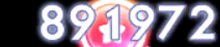

In [8]:
import PIL

# Then set the base width of our image
basewidth = 220

# We want to get the correct aspect ratio, so we can do this by taking the base width and dividing
# it by the actual width of the image
wpercent = (basewidth / float(img.width))

# With that ratio we can just get the appropriate height of the image.
hsize = int((float(img.height) * float(wpercent)))

# resize and specify an approach
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
display(img)

# and run OCR
text = pytesseract.image_to_string(img) 
print(text)
# still can't recognize

### Convert to greyscale
Converting images can be done in many different ways. If we poke around in the PILLOW documentation we find that one of the easiest ways to do this is to use the convert() function and pass in the string 'L'

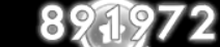

''

In [9]:
grey = img.convert("L")
display(grey)
text = pytesseract.image_to_string(grey)
text
# no effect...

### Binarization
It's to separate into two distinct parts - in this case, black and white. Binarization is enacted through a process called __thresholding__. If a pixel value is greater than a threshold value, it will be converted to a black pixel; if it is lower than the threshold it will be converted to a white pixel. 
This process eliminates noise in the OCR process allowing greater image recognition accuracy. 
With Pillow, this process is straightforward.

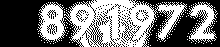

''

In [10]:
bi_img = img.convert('1')
display(bi_img)
text = pytesseract.image_to_string(bi_img)
text
# still no effect...

In [11]:
# can create a function myself
# example below is the one from class
def binarize(image_to_transform, threshold):
    # now, lets convert that image to a single greyscale image using convert()
    output_image=image_to_transform.convert("L")
    # the threshold value is usually provided as a number between 0 and 255, which
    # is the number of bits in a byte.
    # the algorithm for the binarization is pretty simple, go through every pixel in the
    # image and, if it's greater than the threshold, turn it all the way up (255), and
    # if it's lower than the threshold, turn it all the way down (0).
    # so lets write this in code. First, we need to iterate over all of the pixels in the
    # image we want to work with
    for x in range(output_image.width):
        for y in range(output_image.height):
            # for the given pixel at w,h, lets check its value against the threshold
            if output_image.getpixel((x,y)) < threshold: #note that the first parameter is actually a tuple object
                # lets set this to zero
                output_image.putpixel( (x,y), 0 )
            else:
                # otherwise lets set this to 255
                output_image.putpixel( (x,y), 255 )
    #now we just return the new image
    return output_image

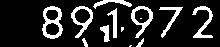

'Shee how Aav'

In [12]:
bw_img = binarize(img, 250)
display(bw_img)
pytesseract.image_to_string(bw_img)

In [62]:
def outline(image, ths_range):
    output = image.copy()
    for x in range(output.width):
        for y in range(output.height):
            if output.getpixel((x, y)) >= ths_range[0] and output.getpixel((x, y)) <= ths_range[1]:
                output.putpixel((x, y), 0)
            else:
                output.putpixel((x, y), 255)
    return output

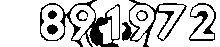

''

In [67]:
trial = outline(grey, [90, 170])
display(trial)
txt = pytesseract.image_to_string(trial)
txt

## Recognize texts within a photograph

First, we need to determine a bounding box for that sign. I'm going to show you a short-cut to make this easier in an optional video in this module, but for now lets just use the bounding box I decided on

#### Jupyter widgets

Sometimes you want to interact with a function you have created and call it multiple times with different parameters. For instance, if we wanted to draw a red box around a portion of an image to try and fine tune the crop location. Widgets are one way to do this quickly in the browser without having to learn how to write a large desktop application.

Lets check it out. First we want to import the Image and ImageDraw classes from the PILLOW package

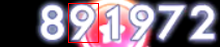

In [69]:
from PIL import Image, ImageDraw

# Then we want to import the interact class from the widgets package
from ipywidgets import interact

# Ok, our setup is done. Now we're going to use the interact decorator to indicate
# that we want to wrap the python function. We do this using the @ sign. This will
# take a set of parameters which are identical to the function to be called. Then Jupyter
# will draw some sliders on the screen to let us manipulate these values. Decorators,
# which is what the @ sign is describing, are standard python statements and just a
# short hand for functions which wrap other functions. They are a bit advanced though, so
# we haven't talked about them in this course, and you might just have to have some faith
@interact(left=68, top=3, right=98, bottom=42)

# Now we just write the function we had before
def draw_border(left, top, right, bottom):
    image=img.copy()
    drawing_object=ImageDraw.Draw(image)
    drawing_object.rectangle((left,top,right,bottom), fill = None, outline ='red')
    display(image)

In [72]:
bounding_box=(98, 3, 120, 42)

# Now, lets crop the image
piece = img.crop(bounding_box)
display(piece)
bi_piece = binarize(piece, 250)
display(bi_piece)
pytesseract.image_to_string(bi_piece)

''

Sometimes it can enlarge the image using different methods: `Image.NEAREST`, `Image.BOX`, `Image.BILINEAR`, `Image.HAMMING`, `Image.BICUBIC`, `Image.LANCZOS`

In [ ]:
new_size=(little_sign.width*10,little_sign.height*10)
display(little_sign.resize( new_size, Image.NEAREST))

# I think we should be able to find something better. I can read it, but it looks
# really pixelated. Lets see what all the different resize options look like
options=[Image.NEAREST, Image.BOX, Image.BILINEAR, Image.HAMMING, Image.BICUBIC, Image.LANCZOS]
for option in options:
    # lets print the option name
    print(option)
    # lets display what this option looks like on our little sign
    display(little_sign.resize( new_size, option))

In [ ]:
# Ok, that text is pretty useless. How should we pick the best binarization
# to use? Well, there are some methods, but lets just try something very simple to
# show how well this can work. We have an english word we are trying to detect, "FOSSIL".
# If we tried all binarizations, from 0 through 255, and looked to see if there were
# any english words in that list, this might be one way. So lets see if we can
# write a routine to do this.
#
# First, lets load a list of english words into a list. I put a copy in the readonly
# directory for you to work with
eng_dict=[]
with open ("readonly/words_alpha.txt", "r") as f:
    data=f.read()
    # now we want to split this into a list based on the new line characters
    eng_dict=data.split("\n")

# Now lets iterate through all possible thresholds and look for an english word, printing
# it out if it exists
for i in range(150,170):
    # lets binarize and convert this to s tring values
    strng=pytesseract.image_to_string(binarize(bigger_sign,i))
    # We want to remove non alphabetical characters, like ([%$]) from the text, here's
    # a short method to do that
    # first, lets convert our string to lower case only
    strng=strng.lower()
    # then lets import the string package - it has a nice list of lower case letters
    import string
    # now lets iterate over our string looking at it character by character, putting it in
    # the comaprison text
    comparison=''
    for character in strng:
        if character in string.ascii_lowercase:
            comparison=comparison+character
    # finally, lets search for comparison in the dictionary file
    if comparison in eng_dict:
        # and print it if we find it
        print(comparison)